In [5]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install tensorflow

  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.4 MB/s eta 0:00:00
  Using cached protobuf-4.25.2-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached cachetools-5.3.2-py3-none-any.whl.metadata (5.2 kB)
  Using cached pyasn1_modules-0.3.0-py2.py3-none-any.whl (181 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached idna-3.6-py3-none-any.whl.metadata (9.9 kB)
  Using cached urllib3-2.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached certifi-2023.11.17-py3-none-any.whl.metadata (2.2 kB)
  Using cached pyasn1-0.5.1-py2.py3-none-any.whl.metadata (8.6 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path 
from collections import Counter 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers

In [24]:
char_img

['2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'm',
 'n',
 'p',
 'w',
 'x',
 'y']

In [32]:
import pickle
with open('char_img.pkl', 'wb') as f:
    pickle.dump(char_img, f)

In [33]:
char_img
char_to_num = layers.StringLookup( 
	vocabulary=list(char_img), mask_token=None
) 

num_to_char = layers.StringLookup( 
	vocabulary=char_to_num.get_vocabulary(), 
	mask_token=None, invert=True
) 

In [31]:
# Path to the Dataset 
direc = Path("data") 

dir_img = sorted(list(map(str, list(direc.glob("*.png"))))) 
img_labels = [img.split(os.path.sep)[-1]. 
			split(".png")[0] for img in dir_img] 
char_img = set(char for label in img_labels for char in label) 
char_img = sorted(list(char_img)) 

print("Number of dir_img found: ", len(dir_img)) 
print("Number of img_labels found: ", len(img_labels)) 
print("Number of unique char_img: ", len(char_img)) 
print("Characters present: ", char_img) 

# Batch Size of Training and Validation 
batch_size = 16

# Setting dimensions of the image 
img_width = 200
img_height = 50

# Setting downsampling factor 
downsample_factor = 4

# Setting the Maximum Length 
max_length = max([len(label) for label in img_labels]) 

# Char to integers 
char_to_num = layers.StringLookup( 
	vocabulary=list(char_img), mask_token=None
) 

# Integers to original chaecters 
num_to_char = layers.StringLookup( 
	vocabulary=char_to_num.get_vocabulary(), 
	mask_token=None, invert=True
) 


def data_split(dir_img, img_labels, 
			train_size=0.9, shuffle=True): 
	# Get the total size of the dataset 
	size = len(dir_img) 
	# Create an indices array and shuffle it if required 
	indices = np.arange(size) 
	if shuffle: 
		np.random.shuffle(indices) 
	# Calculate the size of training samples 
	train_samples = int(size * train_size) 
	# Split data into training and validation sets 
	x_train, y_train = dir_img[indices[:train_samples]], img_labels[indices[:train_samples]] 
	x_valid, y_valid = dir_img[indices[train_samples:]], img_labels[indices[train_samples:]] 
	return x_train, x_valid, y_train, y_valid 


# Split data into training and validation sets 
x_train, x_valid,y_train, y_valid = data_split(np.array(dir_img), np.array(img_labels)) 


def encode_sample(img_path, label): 
	# Read the image 
	img = tf.io.read_file(img_path) 
	# Converting the image to grayscale 
	img = tf.io.decode_png(img, channels=1) 
	img = tf.image.convert_image_dtype(img, tf.float32) 
	# Resizing to the desired size 
	img = tf.image.resize(img, [img_height, img_width]) 
	# Transposing the image 
	img = tf.transpose(img, perm=[1, 0, 2]) 
	# Mapping image label to numbers 
	label = char_to_num(tf.strings.unicode_split(label, 
												input_encoding="UTF-8")) 

	return {"image": img, "label": label} 


Number of dir_img found:  1040
Number of img_labels found:  1040
Number of unique char_img:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [34]:
label

'2mpnn'

In [3]:
# Creating training dataset 
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
dataset_train = ( 
	dataset_train.map( 
		encode_sample, num_parallel_calls=tf.data.AUTOTUNE 
	) 
	.batch(batch_size) 
	.prefetch(buffer_size=tf.data.AUTOTUNE) 
) 


# Creating validation dataset 
val_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)) 
val_data = ( 
	val_data.map( 
		encode_sample, num_parallel_calls=tf.data.AUTOTUNE 
	) 
	.batch(batch_size) 
	.prefetch(buffer_size=tf.data.AUTOTUNE) 
)


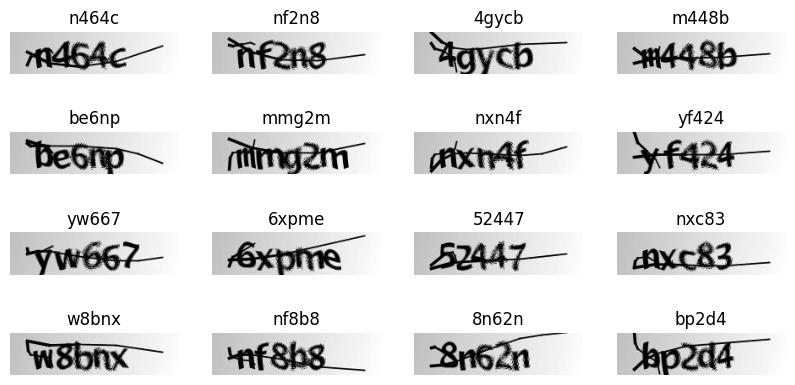

In [4]:
# Visualizing some training data 
_, ax = plt.subplots(4, 4, figsize=(10, 5)) 
for batch in dataset_train.take(1): 
	dir_img = batch["image"] 
	img_labels = batch["label"] 
	for i in range(16): 
		img = (dir_img[i] * 255).numpy().astype("uint8") 
		label = tf.strings.reduce_join(num_to_char( 
			img_labels[i])).numpy().decode("utf-8") 
		ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray") 
		ax[i // 4, i % 4].set_title(label) 
		ax[i // 4, i % 4].axis("off") 
plt.show() 


In [5]:
img.shape

(200, 50, 1)

In [6]:
test_img.shape

NameError: name 'test_img' is not defined

In [7]:
# CTC loss calculation 
class LayerCTC(layers.Layer): 
	def __init__(self, name=None): 
		super().__init__(name=name) 
		self.loss_fn = keras.backend.ctc_batch_cost 

	def call(self, y_true, y_pred): 
		# Compute the training-time loss value 
		batch_len = tf.cast(tf.shape(y_true)[0], 
							dtype="int64") 
		input_length = tf.cast(tf.shape(y_pred)[1], 
							dtype="int64") 
		label_length = tf.cast(tf.shape(y_true)[1], 
							dtype="int64") 

		input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64") 
		label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64") 

		loss = self.loss_fn(y_true, y_pred, 
							input_length, label_length) 
		self.add_loss(loss) 

		# Return Computed predictions 
		return y_pred 


def model_build(): 
	# Define the inputs to the model 
	input_img = layers.Input( 
		shape=(img_width, img_height, 1), 
		name="image", dtype="float32"
	) 
	img_labels = layers.Input(name="label", 
							shape=(None,), 
							dtype="float32") 

	# First convolutional block 
	x = layers.Conv2D( 
		32, 
		(3, 3), 
		activation="relu", 
		kernel_initializer="he_normal", 
		padding="same", 
		name="Conv1", 
	)(input_img) 
	x = layers.MaxPooling2D((2, 2), name="pool1")(x) 

	# Second convolutional block 
	x = layers.Conv2D( 
		64, 
		(3, 3), 
		activation="relu", 
		kernel_initializer="he_normal", 
		padding="same", 
		name="Conv2", 
	)(x) 
	x = layers.MaxPooling2D((2, 2), name="pool2")(x) 

	# Reshaping the output before passing to RNN 
	new_shape = ((img_width // 4), (img_height // 4) * 64) 
	x = layers.Reshape(target_shape=new_shape, name="reshape")(x) 
	x = layers.Dense(64, activation="relu", name="dense1")(x) 
	x = layers.Dropout(0.2)(x) 

	# RNNs 
	x = layers.Bidirectional(layers.LSTM( 
		128, return_sequences=True, dropout=0.25))(x) 
	x = layers.Bidirectional(layers.LSTM( 
		64, return_sequences=True, dropout=0.25))(x) 

	# Output layer 
	x = layers.Dense( 
		len(char_to_num.get_vocabulary()) + 1, 
		activation="softmax", name="dense2")(x) 

	# Calculate CTC loss at each step 
	output = LayerCTC(name="ctc_loss")(img_labels, x) 

	# Defining the model 
	model = keras.models.Model( 
		inputs=[input_img, img_labels], 
		outputs=output, 
		name="ocr_model_v1") 
	opt = keras.optimizers.Adam() 

	# Compile the model 
	model.compile(optimizer=opt) 

	return model 


In [8]:
# Build the model 
model = model_build() 
model.summary()


Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

In [9]:
val_data

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [10]:
# Early Stopping Parameters and EPOCH 
epochs = 100
early_stopping_patience = 10


early_stopping = keras.callbacks.EarlyStopping( 
	monitor="val_loss", 
	patience=early_stopping_patience, 
	restore_best_weights=True
) 

# Training the model 
history = model.fit( 
	dataset_train, 
	validation_data=val_data, 
	epochs=epochs, 
	callbacks=[early_stopping], 
) 


Epoch 1/100
59/59 [==============================] - 7s 78ms/step - loss: 20.4524 - val_loss: 16.4035
Epoch 2/100
59/59 [==============================] - 6s 100ms/step - loss: 16.3569 - val_loss: 16.3774
Epoch 3/100
59/59 [==============================] - 4s 72ms/step - loss: 16.3441 - val_loss: 16.3657
Epoch 4/100
59/59 [==============================] - 4s 75ms/step - loss: 16.3380 - val_loss: 16.3637
Epoch 5/100
59/59 [==============================] - 5s 77ms/step - loss: 16.3296 - val_loss: 16.3576
Epoch 6/100
59/59 [==============================] - 4s 74ms/step - loss: 16.3210 - val_loss: 16.3550
Epoch 7/100
59/59 [==============================] - 6s 104ms/step - loss: 16.3112 - val_loss: 16.3431
Epoch 8/100
59/59 [==============================] - 4s 74ms/step - loss: 16.2955 - val_loss: 16.3087
Epoch 9/100
59/59 [==============================] - 5s 85ms/step - loss: 16.2695 - val_loss: 16.2754
Epoch 10/100
59/59 [==============================] - 5s 83ms/step - loss: 16.20

In [14]:
prediction_model = tf.keras.models.load_model('decaptcha_model')

In [11]:
# Get the Model 
prediction_model = keras.models.Model( 
	model.get_layer(name="image").input, 
	model.get_layer(name="dense2").output 
) 
prediction_model.summary() 


def decode_batch_predictions(pred): 
	input_len = np.ones(pred.shape[0]) * pred.shape[1] 
	results = keras.backend.ctc_decode(pred, 
									input_length=input_len, 
									greedy=True)[0][0][ 
		:, :max_length 
	] 
	output_text = [] 
	for res in results: 
		res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8") 
		output_text.append(res) 
	return output_text 


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

In [12]:
prediction_model.save('decaptcha_model')

INFO:tensorflow:Assets written to: decaptcha_model/assets


INFO:tensorflow:Assets written to: decaptcha_model/assets


1/1 [==============================] - 0s 454ms/step


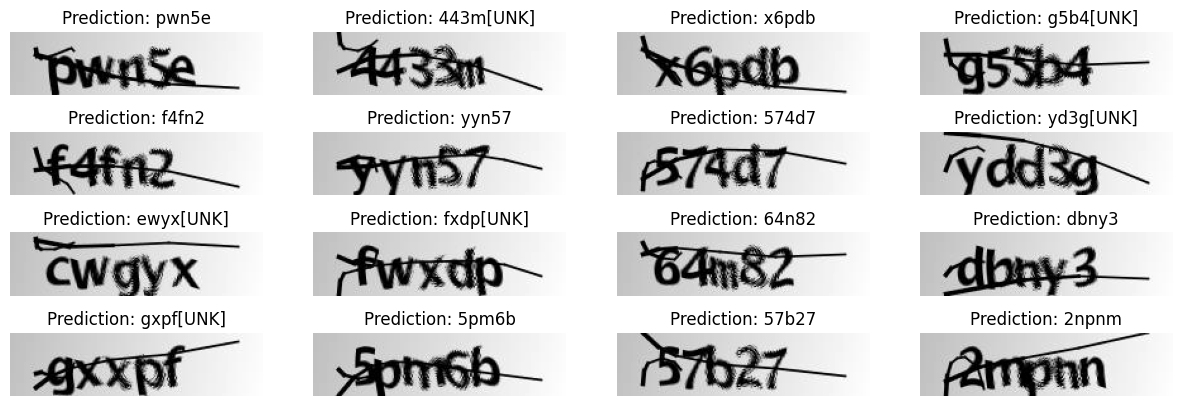

In [15]:
# Check the validation on a few samples 
for batch in val_data.take(1): 
	batch_images = batch["image"] 
	batch_labels = batch["label"] 


	preds = prediction_model.predict(batch_images) 
	pred_texts = decode_batch_predictions(preds) 


	orig_texts = [] 
	for label in batch_labels: 
		label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8") 
		orig_texts.append(label) 


	_, ax = plt.subplots(4, 4, figsize=(15, 5)) 
	for i in range(len(pred_texts)): 
		img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8) 
		img = img.T 
		title = f"Prediction: {pred_texts[i]}"
		ax[i // 4, i % 4].imshow(img, cmap="gray") 
		ax[i // 4, i % 4].set_title(title) 
		ax[i // 4, i % 4].axis("off") 
plt.show()


In [16]:
def encode_sample(img_path): 
	# Read the image 
	img = tf.io.read_file(img_path) 
	# Converting the image to grayscale 
	img = tf.io.decode_png(img, channels=1) 
	img = tf.image.convert_image_dtype(img, tf.float32) 
	# Resizing to the desired size 
	img = tf.image.resize(img, [img_height, img_width]) 
	# Transposing the image 
	img = tf.transpose(img, perm=[1, 0, 2])
	img = (img * 255).numpy().astype("uint8")
	return img

In [17]:
test_img = encode_sample('data/226md.png')
test_img = np.reshape(test_img, (-1, 200, 50, 1))

In [18]:
decode_batch_predictions(prediction_model.predict(test_img))

1/1 [==============================] - 0s 455ms/step


['6425[UNK]']